In [1]:
# Standard library imports
import glob
import os
import shutil
import time

# Third party imports
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.ndimage import generic_filter
from scipy.spatial import distance
import shapefile as shp
from shapely.geometry import Point
import vtk

# Flopy imports
import flopy
import flopy.utils
from flopy.discretization import StructuredGrid
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
from flopy.mf6.utils.reference import SpatialReference
from flopy.modflow import ModflowNwt, ModflowRch, ModflowStr
from flopy.utils import CellBudgetFile, Raster, ZoneBudget, binaryfile as bf
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d

print("Modules imported successfully.")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Modules imported successfully.


In [2]:
# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

In [3]:

os.chdir('C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS')

In [4]:
import mod_utils_SS
import importlib
importlib.reload(mod_utils_SS)

<module 'mod_utils_SS' from 'c:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow_SS\\mod_utils_SS.py'>

In [5]:
# Geometry
geometry_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Marylidia_data\\DEM\\DEM"
shp_Gondebeek_path = os.path.join(geometry_path,"Catchment_Gondebeek_v2.shp")
raster_DEM_path= os.path.join(geometry_path,'DEM_Gondebeek.asc')
raster_A100t_path = os.path.join(geometry_path,'A0100_t.asc')
raster_Paniseliaan_Brusseliaan_Aquifer_path=os.path.join(geometry_path,'A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc')
raster_Paniseliaan_Aquitard_path= os.path.join(geometry_path,'A0700_Paniseliaan_Aquitard.asc')    
raster_eperiaan_Aquifer_path= os.path.join(geometry_path,'A0800_Leperiaan_Aquifer.asc')    

In [6]:
modelname = 'Gondebeek_SS'
model_dir = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow_SS"

In [7]:
# Load shape
shp_obj = shp.Reader(shp_Gondebeek_path)

# Read shape
feature = shp_obj.shapeRecords()[0]

# Domain extension
bbox = feature.shape.bbox
Lx = -(bbox[0]-bbox[2]) #m
Ly = -(bbox[1]-bbox[3]) #m

# Horizontal discretization
delr = 100
delc = 100

# Number of model rows, and cols
nrow = Ly / delr
ncol = Lx / delc

# Actualizar nrow y ncol
nrow = int(np.round(nrow+.5))
ncol = int(np.round(ncol+.5))

# Actualizar Lx y Ly
Ly = nrow*delr
Lx = ncol*delc

# Origins round to left and up
xul = int(bbox[0]//100*100)
yul = int((bbox[3])//100*100+100)

# Number of layers between guide layers
gls_lays = np.array([1,1,1,1])

# Total N of layers are calculated
nlay = gls_lays.sum()

In [8]:
file_list = [raster_DEM_path,raster_A100t_path,raster_Paniseliaan_Brusseliaan_Aquifer_path,raster_Paniseliaan_Aquitard_path,raster_eperiaan_Aquifer_path]

interp_elevs = mod_utils_SS.interpolate_to_grid(file_list, xul, yul, nrow, ncol, delr, delc)


In [9]:
interp_elevs = mod_utils_SS.check_layer_elevs(interp_elevs,1.01)
len(gls_lays)
len(interp_elevs)

5

In [10]:
botm = np.zeros((nlay,nrow,ncol),dtype=float)
botm = mod_utils_SS.fill_botm_array(botm,interp_elevs,gls_lays)
topm = mod_utils_SS.fill_topm_array(botm,interp_elevs,gls_lays)

In [31]:
# Fecha inicial y final
year_0 = 2015; month_0 = 1; day_0 = 1 
year_F = 2015; month_F = 1; day_F = 31 

SP = mod_utils_SS.Constru_SP(year_0, month_0, day_0, year_F, month_F, day_F,steady_0=True, steady=True, timestep=24, scale='d', n_scale=1)
perlen, fecha_inicialSP, fecha_finalSP, nstp, tsmult, steady = SP
nper = len(perlen)


In [32]:
top=topm[0]
top

array([[-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       ...,
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09]])

In [33]:
mf2005_exe = os.path.join('MODFLOW-NWT.exe')  # Path to MODFLOW-2005 NWT executable
#noflow = mod_utils.active_cell(sim,shp_obj)
sim = flopy.modflow.Modflow(modelname=modelname, model_ws=model_dir,
                          version='mf2005', exe_name=mf2005_exe,
                          structured=True)
                          
                          
dis = flopy.modflow.ModflowDis(sim, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=interp_elevs[0], botm=botm,
                              xul=xul, yul=yul, nper=nper,steady=steady,
                               perlen=perlen,nstp=nstp,tsmult=tsmult)

lpf = flopy.modflow.ModflowLpf(sim, ipakcb=50, hk=500, laytyp=4, layvka=1, laywet=1, wetdry=-0.01, iwetit=100, ihdwet=1)
# Write BAS package
# Convert the Util3d object to a numpy array

noflow = mod_utils_SS.active_cell(sim,shp_obj)
# Create a mask where botm and top are not NaN
mask = np.logical_and(~np.isnan(botm), ~np.isnan(top))

# Create an IBOUND array based on the mask
ibound = np.where(mask, 1, 0)

# Use this IBOUND array to create the ModflowBas object
bas = flopy.modflow.ModflowBas(sim, strt=interp_elevs[0], ibound=noflow)
botm_array = dis.botm.array

nstress = sim.dis.nper

# Get the number of time steps for each stress period
num_time_steps = sim.dis.nstp.array



# Define the OC stress period data
oc_spd = {(i, sim.dis.nstp.array[i] - 1): ['save head', 'save budget'] 
          for i in range(sim.dis.nper)}

# Create the OC package
oc = flopy.modflow.ModflowOc(sim, stress_period_data=oc_spd, compact=True)
oc.iuhead = 51  # Assign a unit number to the head file

# Write the OC package
oc.write_file()
sim.write_input()

# Create the OC package
oc = flopy.modflow.ModflowOc(sim, stress_period_data=oc_spd, compact=True)
oc.iuhead = 51  # Assign a unit number to the head file

# Write the OC package
oc.write_file()
sim.write_input()


c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 14 of package OC already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'OC' package.
  warn(


In [34]:
# Load the shapefile for K and s:
k_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Marylidia_data\DEM\DEM\provincie_k_clipped.shp"
s_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Marylidia_data\DEM\DEM\provincie_s_clipped.shp"
k = gpd.read_file(k_path)
s = gpd.read_file(s_path)
# Print the attributes of the shapefile
print(k.columns)
print(s.columns)

Index(['node', 'row', 'column', 'icellpe_1_', 'icellpe_2_', 'icellpe_3_',
       'icellpe_4_', 'icellpe_5_', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k33_1',
       'k33_2', 'k33_3', 'k33_4', 'k33_5', 'geometry'],
      dtype='object')
Index(['node', 'row', 'column', 'iconvert_1', 'iconvert_2', 'iconvert_3',
       'iconvert_4', 'iconvert_5', 'ss_1', 'ss_2', 'ss_3', 'ss_4', 'ss_5',
       'sy_1', 'sy_2', 'sy_3', 'sy_4', 'sy_5', 'geometry'],
      dtype='object')


In [35]:
#set hydraulic properties:
mod_utils_SS.set_hydraulic_properties(sim, k, s, bbox, delr, delc, ['k_1', 'k_2', 'k_3', 'k_3'], 
                                   ['k33_1', 'k33_2', 'k33_3', 'k33_3'],['sy_1', 'sy_2', 'sy_3', 'sy_3'], ['ss_1', 'ss_2', 'ss_3', 'ss_3'] )
#write lpf package 

sim.lpf.write_file()

In [36]:
sim.lpf.check()


LPF PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    negative horizontal anisotropy values
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative specific yield values
    specific yield values below checker threshold of 0.01
    specific yield values above checker threshold of 0.5



In [37]:
#now an average recharge data is added for all Sp's this must be changed in the future

# Calculate the daily recharge rate in meters per day
recharge_rate = 703.0074999999999/ 1000 / 365/3  # Convert from mm/year to m/day (and the third part only is infiltrated)

# Create a 2D array with the recharge rate

recharge_array = [[recharge_rate for _ in range(ncol)] for _ in range(nrow)]

# Create a dictionary with the recharge rate for each stress period
nper = sim.dis.nper
recharge = {kper: recharge_array for kper in range(nper)}

# Create the recharge package
rch = flopy.modflow.ModflowRch(sim, rech=recharge,ipakcb=50)

# Write the package
rch.write_file()


In [38]:


# Define the path to the .npy file
initial_head_path = os.path.join('C:', os.sep, 'Users', 'sebas', 'Documents', 'UGent', 'Sem 3', 'Thesis', 'GondebeekModel', 'Modflow', 'initial_head.npy')

# Load the head data from the .npy file
initial_head = np.load(initial_head_path)

# Define the path to the model
model_path = os.path.join('C:', os.sep, 'Users', 'sebas', 'Documents', 'UGent', 'Sem 3', 'Thesis', 'GondebeekModel', 'Modflow_SS')

# Load the model
model = flopy.modflow.Modflow.load('Gondebeek_SS.nam', model_ws=model_path)

# Set the initial head in the model
bas = flopy.modflow.ModflowBas(model, strt=initial_head)

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(


In [39]:
#First: Clip river shapefile (WLas):

river_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Streams\\Shapefile"
shp_river = os.path.join(river_path,"Wlas.shp")


# Load your polygon and line shapefiles
polygon = gpd.read_file(shp_Gondebeek_path)
line = gpd.read_file(shp_river)

# Reproject the line GeoDataFrame to match the CRS of the polygon GeoDataFrame
line = line.to_crs(polygon.crs)

# Perform the clip operation
clipped = gpd.clip(line, polygon)

shp_river_clipped = os.path.join(river_path,"Wlas_clipped.shp")
# Save the clipped part to a new shapefile
clipped.to_file(shp_river_clipped)

In [40]:
from rtree import index
import geopandas as gpd
from shapely.geometry import Polygon

# Get the top elevation array and active cell data from your model
top_elev = sim.dis.top.array
ibound = sim.bas6.ibound.array  # get the array of active cells

clipped = gpd.read_file(shp_river_clipped)
layer = 0  # layer number (only layer 1)
# Create a spatial index
idx = index.Index()

# Populate spatial index with bounding boxes of active cells
for row in range(sim.modelgrid.nrow):
    for col in range(sim.modelgrid.ncol):
        if ibound[layer, row, col] > 0:
            x_center = sim.modelgrid.xcellcenters[row, col]
            y_center = sim.modelgrid.ycellcenters[row, col]
            dx = sim.modelgrid.delc[row] / 2
            dy = sim.modelgrid.delr[col] / 2
            bounds = (x_center - dx, y_center - dy, x_center + dx, y_center + dy)
            idx.insert((row * sim.modelgrid.ncol) + col, bounds)

# Initialize the segment and reach numbers
segment = 1
reach = 1
flow = 1


# Convert the shapefile to a list of [layer, row, column, segment, reach, flow, strhc1, strtop, slope, strthick, width, rough] for each reach
stream_data = []
processed_cells = set()  # Set to keep track of processed cells

for index, data in clipped.iterrows():
    # Get the vertices of the LineString
    vertices = list(data['geometry'].coords)
    
    for i in range(len(vertices) - 1):
        # Calculate the minimum and maximum x and y coordinates
        minx = min(vertices[i][0], vertices[i+1][0])
        miny = min(vertices[i][1], vertices[i+1][1])
        maxx = max(vertices[i][0], vertices[i+1][0])
        maxy = max(vertices[i][1], vertices[i+1][1])
        
        # Get intersecting cells using spatial index
        coordinates = (minx, miny, maxx, maxy)
        intersecting_cells = list(idx.intersection(coordinates))
        
        if not intersecting_cells:
            continue
        
        # Process only the intersecting active cells
        for cell_index in intersecting_cells:
            row = cell_index // sim.modelgrid.ncol
            col = cell_index % sim.modelgrid.ncol
            
            # Skip the specific cells
            if (row, col) in [(1, 52), (6, 58)]:
                continue
            
            # Skip if the cell has already been processed
            if (row, col) in processed_cells:
                continue
            
            layer = 0  # layer number (only layer 1)
            # Check if the cell is within the active domain
            if ibound[layer, row, col] > 0:
                # Calculate the reach length as the distance between the centers of the cells
                next_row, next_col = sim.modelgrid.intersect(vertices[i+1][0], vertices[i+1][1])
                # Check if the next cell is within the active domain
                if ibound[layer, next_row, next_col] > 0:
                    rchlen = ((sim.modelgrid.xcellcenters[row, col] - sim.modelgrid.xcellcenters[next_row, next_col])**2 + 
                              (sim.modelgrid.ycellcenters[row, col] - sim.modelgrid.ycellcenters[next_row, next_col])**2)**0.5
                    strtop = top_elev[row, col]  # streambed top (top elevation of the cell)
                    slope = 0.001  # stream slope (using a small constant value for now)
                    strthick = 1.0  # streambed thickness
                    strhc1 = 100.0  # streambed conductance
                    stage = 1.0  # initial stream stage
                    width = 1.0  # stream width
                    rough = 1.0  # roughness coefficient
                    stream_data.append([layer, row, col, segment, reach, flow, strhc1, stage, strtop, slope, strthick, width, rough])
                    reach += 1  # increment the reach number
                    processed_cells.add((row, col))  # Add the cell to the set of processed cells

    segment += 1  # increment the segment number
    reach = 1  # reset the reach number for the next segment

# Get the number of stress periods
nstress = sim.dis.nper

# Define the stream reach data for the first stress period
stress_period_data = {0: stream_data}

# Replicate the first stress period data for all stress periods
for i in range(1, nstress):
    stress_period_data[i] = stress_period_data[0]

# Define some default segment data
segment_data = {i: [[1]*11 for _ in range(len(stream_data))] for i in range(nstress)}

# Create the STR package
str = flopy.modflow.ModflowStr(sim, mxacts=len(stream_data), nss=len(stream_data), stress_period_data=stress_period_data, segment_data=segment_data, istcb2=0, ipakcb=50, options=['FLOW'])

# Write the package
str.write_file()
sim.write_input()

str.check()


STR PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



In [41]:
# Load the model
sim = flopy.modflow.Modflow.load('Gondebeek_SS.nam')

# Change the version to 'mfnwt'
sim.version = 'mfnwt'

# Check if the PCG package exists before trying to remove it
if 'PCG' in sim.get_package_list():
    sim.remove_package('PCG')

# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')

# Check if the LPF package exists before trying to remove it
if 'LPF' in sim.get_package_list():
    lpf = sim.get_package('LPF')
else:
    # Try to load the LPF package from a file
    lpf_file = 'Gondebeek.lpf'
    if os.path.exists(lpf_file):
        lpf = flopy.modflow.ModflowLpf.load(lpf_file, sim)
    else:
        print("LPF package does not exist in the model or in the file. Cannot create UPW package.")
        lpf = None

if lpf is not None and hasattr(lpf, 'hk'):
    sim.remove_package('LPF')
    # Create a new UPW package with the same parameters as the LPF package
    upw = flopy.modflow.ModflowUpw(sim, hk=lpf.hk.array, 
                                   vka=lpf.vka.array, 
                                   sy=lpf.sy.array, 
                                   ss=lpf.ss.array, 
                                   laytyp=lpf.laytyp.array,
                                   ipakcb=50)
    # Add the new UPW package to the model
    sim.add_package(upw)
else:
    print("LPF package does not have 'hk' attribute. Cannot create UPW package.")

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 31 of package UPW already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UPW' package.
  warn(


In [42]:

# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')
# Create a new NWT solver with custom parameters
nwt = flopy.modflow.ModflowNwt(sim, 
                               headtol=0.001, 
                               fluxtol=700, 
                               maxiterout=4000, 
                               thickfact=1e-7, 
                               linmeth=2, 
                               iprnwt=1, 
                               ibotav=0, 
                               dbdtheta=0.8, 
                               dbdkappa=0.4, 
                               dbdgamma=0.5, 
                               momfact=0.05, 
                               backflag=1, 
                               maxbackiter=400, 
                               backtol=1.5, 
                               backreduce=0.9, 
                               iacl=2, 
                               norder=1, 
                               level=6, 
                               north=4, 
                               iredsys=1, 
                               rrctols=0.0, 
                               idroptol=1, 
                               epsrn=1e-3, 
                               hclosexmd=1e-3, 
                               mxiterxmd=250,
                               options='SPECIFIED')

# Add the new NWT package to the model
sim.add_package(nwt)

# Set the path to the MODFLOW-NWT executable
sim.exe_name = 'MODFLOW-NWT.exe'

# Write the entire model to disk
sim.write_input()
sim.check()

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 32 of package NWT already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'NWT' package.
  warn(



Gondebeek_SS MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    RCH package: Mean R/T is between 2e-08 and 0.0002
    RCH package: Variable NRCHOP set to 3.
    STR package: BC indices valid
    STR package: not a number (Nan) entries
    STR package: BC in inactive cells
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity 

In [43]:
# Run the model
sim.run_model()

FloPy is using the following executable to run the model: MODFLOW-NWT.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: Gondebeek_SS.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/24 10:48:58

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.
 Solving:

(True, [])

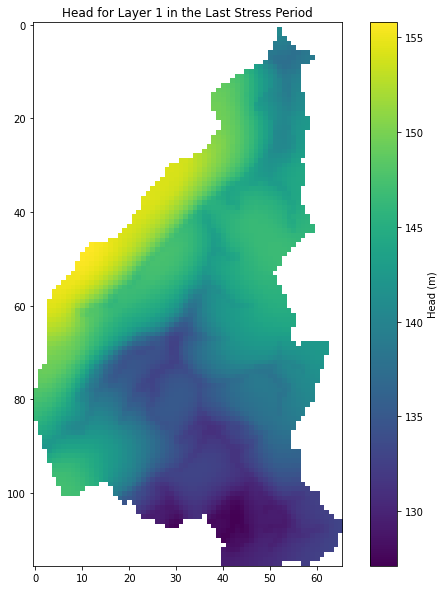

In [44]:

# Load the head data
hds = flopy.utils.HeadFile('Gondebeek_SS.hds')

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values lower than -900
head = np.ma.masked_where(head < -900, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

In [45]:
# Load the model
modelname = 'Gondebeek_SS'  # replace with your model name if different
sim = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the ibound array from the bas package of the model
ibound = sim.bas6.ibound.array

# Create the zone array from the ibound array
zon = np.where(ibound == 0, 1, ibound)

# Get the cell-by-cell budget file name from the model
cbc_file = "Gondebeek_SS.cbc"

# Check if the file exists
if os.path.exists(cbc_file):
    print("File exists")
else:
    print("File does not exist")

# Create a CellBudgetFile object
cbc = CellBudgetFile(cbc_file)

# Get the kstpkper from the cell budget file
kstpkper = cbc.get_kstpkper()

# Check if kstpkper is not empty
if kstpkper:
    # Initialize an empty list to store the budget DataFrames
    dfs = []

    # Loop over all kstpkper values
    for kstp, kper in kstpkper:
        # Create a ZoneBudget object for the current time step and stress period
        zb = ZoneBudget(cbc_file, zon, kstpkper=(kstp, kper))

        # Convert the budget to a DataFrame and add it to the list
        dfs.append(zb.get_dataframes())

    # Concatenate all budget DataFrames
    budget_df = pd.concat(dfs)

    # Save the budget to a CSV file
    f_out = f"{modelname}_output.csv"
    budget_df.to_csv(f_out)

    # Print the contents of the CSV file for the last time step and stress period
    print(pd.read_csv(f_out).to_string(index=False))
else:
    print("kstpkper is empty")

File exists
 totim                name       ZONE_1
   1.0        FROM_STORAGE     0.000000
   1.0  FROM_CONSTANT_HEAD     0.000000
   1.0       FROM_RECHARGE 27914.852000
   1.0 FROM_STREAM_LEAKAGE     0.000000
   1.0         FROM_ZONE_1     0.000000
   1.0            TOTAL_IN 27914.852000
   1.0          TO_STORAGE     0.000000
   1.0    TO_CONSTANT_HEAD     0.000000
   1.0         TO_RECHARGE     0.000000
   1.0   TO_STREAM_LEAKAGE 27914.860000
   1.0           TO_ZONE_1     0.000000
   1.0           TOTAL_OUT 27914.860000
   1.0              IN-OUT     0.007812
   1.0 PERCENT_DISCREPANCY     0.000028
   2.0        FROM_STORAGE     2.490638
   2.0  FROM_CONSTANT_HEAD     0.000000
   2.0       FROM_RECHARGE 27914.852000
   2.0 FROM_STREAM_LEAKAGE     0.000000
   2.0         FROM_ZONE_1     0.000000
   2.0            TOTAL_IN 27917.342000
   2.0          TO_STORAGE     2.487637
   2.0    TO_CONSTANT_HEAD     0.000000
   2.0         TO_RECHARGE     0.000000
   2.0   TO_STREAM_LEAKAGE 2

Now we have to calibrate this SS state. we need the initial head from the "pseudo tranisent!, also adjust the recharge value to the first that is going to be used!

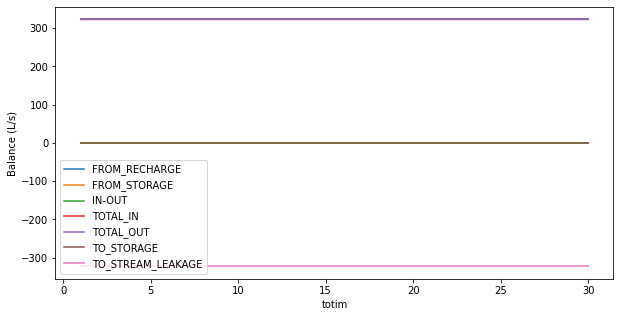

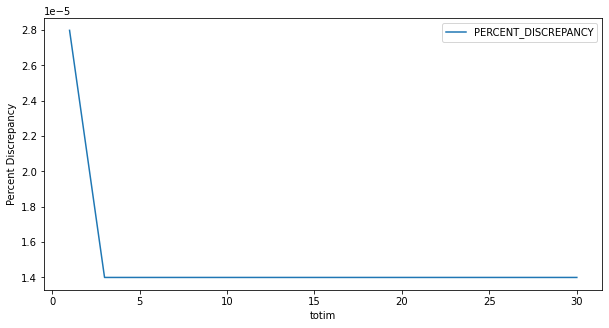

In [46]:
# Load the budget data from the CSV file
budget_df = pd.read_csv(f_out)

# Pivot the DataFrame so that each component becomes a column
pivot_df = budget_df.pivot(index='totim', columns='name', values='ZONE_1')

# Multiply the values of the components that have "TO_" in their name by -1
pivot_df = pivot_df.apply(lambda x: -x if x.name.startswith('TO_') else x)

# Convert the flow values from cubic meters per day to liters per second, excluding the percent discrepancy
for component in pivot_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        pivot_df[component] = pivot_df[component] / 86.4

# Remove the components that are "0.000000" for all of the time steps
pivot_df = pivot_df.drop([col for col in pivot_df.columns if pivot_df[col].abs().sum() == 0], axis=1)

# Plot each component of the balances, excluding the "percent discrepancy"
plt.figure(figsize=(10, 5))
for component in pivot_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        plt.plot(pivot_df.index, pivot_df[component], label=component)

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Balance (L/s)')  # Update the y-axis label

# Show the plot
plt.show()

# Plot the "percent discrepancy" separately
plt.figure(figsize=(10, 5))
plt.plot(pivot_df.index, pivot_df['PERCENT_DISCREPANCY'], label='PERCENT_DISCREPANCY')

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Percent Discrepancy')

# Show the plot
plt.show()